In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import *


import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import PowerTransformer


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import tsa
from scipy import stats

import sys, os
import random 

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
from IPython.display import display
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:

dtypes = {
    "DEvenRLC": "int32",
    "HEvenRLC": "int32",
    "InstrumentID": "str",
    "DSeaBsEven": "int32",
    "NTranSeaBs": "int32",
    "QTitTran": "int32",
    "PTran": "float32",
    "IAnuTran": "float32",
    "buyer_trader": "float32", 
    "buyer": "float32",
    "Buy_PLimSaiOm":"float32",
   "Buy_NSeqOm10":"float32",
   "Buy_DHSaiOmAdf": "float32",
   "seller_trader":"float32",
   "seller":"float32",
   "sell_PLimSaiOm":"float32",
   "sell_NSeqOm10":"float32",
   "sell_DHSaiOmAdf":"float32"
    
    
}

data = pd.read_csv("data-final.csv", dtype=dtypes)

print("Train size:", data.shape)
data.info()




In [3]:
data.to_pickle('all_data_reduced.pkl')

In [4]:
data.shape

(72929669, 18)

In [2]:
data = pd.read_pickle('all_data_reduced.pkl')

In [3]:
data = data[data.DSeaBsEven > 20190830]
data.shape

(17123791, 18)

In [6]:
data.to_pickle("3mII.pkl")

In [2]:
data = pd.read_pickle("3mII.pkl")

In [2]:
data = pd.read_csv("3m.csv")

print(data.shape)
data.info()

(17123791, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17123791 entries, 0 to 17123790
Data columns (total 18 columns):
 #   Column           Dtype  
---  ------           -----  
 0   DEvenRLC         int64  
 1   HEvenRLC         int64  
 2   InstrumentID     object 
 3   DSeaBsEven       int64  
 4   NTranSeaBs       int64  
 5   QTitTran         int64  
 6   PTran            float64
 7   IAnuTran         float64
 8   buyer_trader     float64
 9   buyer            float64
 10  Buy_PLimSaiOm    float64
 11  Buy_NSeqOm10     float64
 12  Buy_DHSaiOmAdf   float64
 13  seller_trader    float64
 14  seller           float64
 15  sell_PLimSaiOm   float64
 16  sell_NSeqOm10    float64
 17  sell_DHSaiOmAdf  float64
dtypes: float64(12), int64(5), object(1)
memory usage: 2.3+ GB


In [3]:
data.head()

,DEvenRLC,HEvenRLC,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf
0,20190819,111557,IRO7MINP0001,20190819,286,5000,21750.0,7.0,1570.0,2478401.0,21750.0,812.0,2.019082e+13,1452.0,2344298.0,21700.0,831.0,2.019082e+13
1,20190819,111557,IRO7MINP0001,20190819,287,5000,21750.0,7.0,1570.0,2478401.0,21750.0,820.0,2.019082e+13,1452.0,2344298.0,21700.0,831.0,2.019082e+13
2,20190819,111540,IRO7SFSP0001,20190819,3172,1693,5850.0,7.0,1371.0,2258853.0,5880.0,6756.0,2.019082e+13,639.0,1410577.0,5850.0,6754.0,2.019082e+13
3,20190819,111540,IRO7SFSP0001,20190819,3175,32307,5880.0,7.0,1371.0,2258853.0,5880.0,6756.0,2.019082e+13,586.0,1385851.0,5880.0,6713.0,2.019082e+13
4,20190818,122125,IRO3KAHZ0001,20190818,2181,46557,11307.0,7.0,569.0,1377126.0,11307.0,3336.0,2.019082e+13,1393.0,2272905.0,11300.0,3606.0,2.019082e+13


In [4]:
data = data[data.InstrumentID=='IRO7CMKP0001']

In [5]:
data.head(30)

,DEvenRLC,HEvenRLC,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf
11396,20191008,95259,IRO7CMKP0001,20191008,29,4002,9791.0,7.0,1395.0,2283371.0,9791.0,34.0,2.019101e+13,644.0,1433497.0,9791.0,36.0,2.019101e+13
11397,20191008,95259,IRO7CMKP0001,20191008,30,17000,9791.0,7.0,1395.0,2283371.0,9791.0,32.0,2.019101e+13,644.0,1433497.0,9791.0,36.0,2.019101e+13
11400,20191008,95259,IRO7CMKP0001,20191008,31,15998,9791.0,7.0,1395.0,2283371.0,9791.0,30.0,2.019101e+13,644.0,1433497.0,9791.0,36.0,2.019101e+13
18511,20191008,101358,IRO7CMKP0001,20191008,49,1990,9510.0,7.0,1395.0,2283371.0,9510.0,54.0,2.019101e+13,280.0,501324.0,9510.0,65.0,2.019101e+13
43986,20190929,120658,IRO7CMKP0001,20190929,24,28,8339.0,7.0,61.0,293433.0,8339.0,154.0,2.019093e+13,1180.0,2110029.0,8339.0,123.0,2.019093e+13
47069,20190929,120126,IRO7CMKP0001,20190929,21,1000,8050.0,7.0,61.0,107365.0,8050.0,146.0,2.019093e+13,332.0,538558.0,8023.0,150.0,2.019093e+13
54724,20191022,92411,IRO7CMKP0001,20191022,7,16218,7961.0,7.0,644.0,1433401.0,7961.0,24.0,2.019102e+13,1523.0,2423803.0,7961.0,20.0,2.019102e+13
58995,20190831,90922,IRO7CMKP0001,20190831,14,11038,7999.0,7.0,644.0,1433401.0,7999.0,27.0,2.019083e+13,692.0,1444950.0,7999.0,32.0,2.019083e+13
68000,20190904,123100,IRO7CMKP0001,20190904,22,275,7821.0,7.0,644.0,1433401.0,7822.0,49.0,2.019090e+13,922.0,1611520.0,7821.0,39.0,2.019090e+13
90189,20190831,95354,IRO7CMKP0001,20190831,22,10000,7999.0,7.0,644.0,1433401.0,7999.0,28.0,2.019083e+13,61.0,338960.0,7999.0,46.0,2.019083e+13


In [6]:
data.DEvenRLC.min(), data.DEvenRLC.max()

(20190831, 20191201)

In [7]:
data.sort_values(by=['DEvenRLC', 'HEvenRLC']).head(30)

,DEvenRLC,HEvenRLC,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf
132286,20190831,90000,IRO7CMKP0001,20190831,4,200,7999.0,7.0,1523.0,2389856.0,8000.0,7.0,2.019083e+13,61.0,11494.0,7999.0,23.0,2.019083e+13
132289,20190831,90000,IRO7CMKP0001,20190831,2,2000,7999.0,7.0,1103.0,1782999.0,8000.0,3.0,2.019083e+13,61.0,11494.0,7999.0,23.0,2.019083e+13
132290,20190831,90000,IRO7CMKP0001,20190831,3,322,7999.0,7.0,1103.0,1782999.0,8000.0,15.0,2.019083e+13,61.0,11494.0,7999.0,23.0,2.019083e+13
3672792,20190831,90000,IRO7CMKP0001,20190831,6,200,7999.0,7.0,1103.0,1787259.0,8000.0,18.0,2.019083e+13,61.0,11494.0,7999.0,23.0,2.019083e+13
4411773,20190831,90000,IRO7CMKP0001,20190831,1,3000,7999.0,7.0,1103.0,1782999.0,8000.0,3.0,2.019083e+13,61.0,85574.0,7990.0,16.0,2.019083e+13
4413500,20190831,90000,IRO7CMKP0001,20190831,5,200,7999.0,7.0,1523.0,2389500.0,8000.0,17.0,2.019083e+13,61.0,11494.0,7999.0,23.0,2.019083e+13
3314826,20190831,90045,IRO7CMKP0001,20190831,8,10000,7999.0,7.0,644.0,1433401.0,7999.0,26.0,2.019083e+13,61.0,338960.0,7999.0,24.0,2.019083e+13
3314827,20190831,90045,IRO7CMKP0001,20190831,9,20000,7999.0,7.0,644.0,1433401.0,7999.0,26.0,2.019083e+13,61.0,315319.0,7999.0,25.0,2.019083e+13
3835281,20190831,90045,IRO7CMKP0001,20190831,7,3219,7999.0,7.0,644.0,1433401.0,7999.0,26.0,2.019083e+13,61.0,11494.0,7999.0,23.0,2.019083e+13
2043765,20190831,90742,IRO7CMKP0001,20190831,10,8792,7999.0,7.0,644.0,1433401.0,7999.0,26.0,2.019083e+13,553.0,813215.0,7999.0,29.0,2.019083e+13


In [4]:
data['X'] = data.DEvenRLC.astype(str)+data.HEvenRLC.astype(str)
data['datetime'] = pd.to_datetime(data['X'], format='%Y%m%d%H%M%S') 


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17123791 entries, 13 to 72929655
Data columns (total 20 columns):
 #   Column           Dtype         
---  ------           -----         
 0   DEvenRLC         int32         
 1   HEvenRLC         int32         
 2   InstrumentID     object        
 3   DSeaBsEven       int32         
 4   NTranSeaBs       int32         
 5   QTitTran         int32         
 6   PTran            float32       
 7   IAnuTran         float32       
 8   buyer_trader     float32       
 9   buyer            float32       
 10  Buy_PLimSaiOm    float32       
 11  Buy_NSeqOm10     float32       
 12  Buy_DHSaiOmAdf   float32       
 13  seller_trader    float32       
 14  seller           float32       
 15  sell_PLimSaiOm   float32       
 16  sell_NSeqOm10    float32       
 17  sell_DHSaiOmAdf  float32       
 18  X                object        
 19  datetime         datetime64[ns]
dtypes: datetime64[ns](1), float32(12), int32(5), object(2)
memory usa

In [11]:
data.datetime.head(30)

11396    2019-10-08 09:52:59
11397    2019-10-08 09:52:59
11400    2019-10-08 09:52:59
18511    2019-10-08 10:13:58
43986    2019-09-29 12:06:58
47069    2019-09-29 12:01:26
54724    2019-10-22 09:24:11
58995    2019-08-31 09:09:22
68000    2019-09-04 12:31:00
90189    2019-08-31 09:53:54
99383    2019-09-02 09:35:30
121763   2019-08-31 10:54:27
132286   2019-08-31 09:00:00
132289   2019-08-31 09:00:00
132290   2019-08-31 09:00:00
142227   2019-08-31 11:07:00
156072   2019-09-02 11:49:01
206389   2019-09-02 09:10:20
207388   2019-09-02 09:49:50
275819   2019-08-31 11:43:18
288698   2019-11-03 09:00:25
336731   2019-09-21 09:02:39
363204   2019-09-25 11:28:37
377095   2019-09-22 11:44:51
400493   2019-09-22 11:47:09
435795   2019-11-16 09:09:54
460666   2019-11-11 16:02:53
460667   2019-11-11 16:03:00
460668   2019-11-11 16:03:07
493426   2019-11-11 16:01:54
Name: datetime, dtype: datetime64[ns]

In [20]:
data.buyer_trader.unique().size

73

In [21]:
data.seller_trader.unique().size

68

In [7]:
d = data.datetime.dt.hour
d

0           11
1           11
2           11
3           11
4           12
            ..
72922238     9
72922239    10
72922246    10
72922250    12
72922252    12
Name: datetime, Length: 14833122, dtype: int64

In [6]:
del data['DEvenRLC']
del data['HEvenRLC']
del data['X']

In [9]:
cats = ['InstrumentID','buyer_trader','seller_trader']#, 'DEvenRLC','HEvenRLC','DSeaBsEven']

for c in cats:
    data[c] = data[c].astype(str)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14833122 entries, 0 to 72922252
Data columns (total 17 columns):
 #   Column           Dtype         
---  ------           -----         
 0   InstrumentID     object        
 1   DSeaBsEven       int32         
 2   NTranSeaBs       int32         
 3   QTitTran         int32         
 4   PTran            float32       
 5   IAnuTran         float32       
 6   buyer_trader     object        
 7   buyer            float32       
 8   Buy_PLimSaiOm    float32       
 9   Buy_NSeqOm10     float32       
 10  Buy_DHSaiOmAdf   float32       
 11  seller_trader    object        
 12  seller           float32       
 13  sell_PLimSaiOm   float32       
 14  sell_NSeqOm10    float32       
 15  sell_DHSaiOmAdf  float32       
 16  datetime         datetime64[ns]
dtypes: datetime64[ns](1), float32(10), int32(3), object(3)
memory usage: 1.3+ GB


In [7]:
data.to_pickle('3mhdatetime_I.pkl')

In [10]:
data = pd.read_pickle('3mhdatetime_I.pkl')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17123791 entries, 13 to 72929655
Data columns (total 17 columns):
 #   Column           Dtype         
---  ------           -----         
 0   InstrumentID     object        
 1   DSeaBsEven       int32         
 2   NTranSeaBs       int32         
 3   QTitTran         int32         
 4   PTran            float32       
 5   IAnuTran         float32       
 6   buyer_trader     float32       
 7   buyer            float32       
 8   Buy_PLimSaiOm    float32       
 9   Buy_NSeqOm10     float32       
 10  Buy_DHSaiOmAdf   float32       
 11  seller_trader    float32       
 12  seller           float32       
 13  sell_PLimSaiOm   float32       
 14  sell_NSeqOm10    float32       
 15  sell_DHSaiOmAdf  float32       
 16  datetime         datetime64[ns]
dtypes: datetime64[ns](1), float32(12), int32(3), object(1)
memory usage: 1.3+ GB


In [11]:
data = data[data.InstrumentID=='IRO7HPKP0001']

In [12]:
data.shape

(386990, 17)

In [6]:
data.head()

,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf,datetime
13,IRO3BDYZ0001,20191016,2156,600,3530.0,7.0,569.0,906667.0,3560.0,3878.0,2.019102e+13,256.0,493489.0,3530.0,3873.0,2.019102e+13,2019-10-16 10:12:54
201,IRO3BDYZ0001,20190929,27,2200,4220.0,7.0,163.0,417011.0,4230.0,1359.0,2.019093e+13,1155.0,2100029.0,4109.0,143.0,2.019093e+13,2019-09-29 09:01:08
209,IRO3BDYZ0001,20190929,3954,12223,4109.0,7.0,453.0,621059.0,4109.0,6380.0,2.019093e+13,1230.0,2148191.0,4109.0,6469.0,2.019093e+13,2019-09-29 09:50:22
210,IRO3BDYZ0001,20190929,3989,60259,4109.0,7.0,1416.0,2314381.0,4109.0,6476.0,2.019093e+13,530.0,792721.0,4109.0,6483.0,2.019093e+13,2019-09-29 09:50:28
326,IRO3BDYZ0001,20190929,1408,500,4139.0,7.0,61.0,149910.0,4139.0,3187.0,2.019093e+13,758.0,1477027.0,4109.0,3594.0,2.019093e+13,2019-09-29 09:22:53


In [13]:
data[data.seller == 1734859]

,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf,datetime
414770,IRO7HPKP0001,20190903,9263,10000,837.0,7.0,238.0,477200.0,837.0,13383.0,2.019090e+13,1092.0,1734859.0,837.0,16088.0,2.019090e+13,2019-09-03 09:33:56
592541,IRO7HPKP0001,20190903,21405,12724,862.0,7.0,1322.0,2234388.0,862.0,33787.0,2.019090e+13,1092.0,1734859.0,860.0,33802.0,2.019090e+13,2019-09-03 10:33:52
592542,IRO7HPKP0001,20190903,21436,24004,865.0,7.0,1322.0,2234388.0,865.0,33911.0,2.019090e+13,1092.0,1734859.0,865.0,33884.0,2.019090e+13,2019-09-03 10:34:20
592543,IRO7HPKP0001,20190903,21491,2584,865.0,7.0,1322.0,2234388.0,866.0,34034.0,2.019090e+13,1092.0,1734859.0,865.0,34012.0,2.019090e+13,2019-09-03 10:34:56
592544,IRO7HPKP0001,20190903,21370,12214,862.0,7.0,1322.0,2227689.0,862.0,33690.0,2.019090e+13,1092.0,1734859.0,862.0,33656.0,2.019090e+13,2019-09-03 10:33:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64818642,IRO7HPKP0001,20190903,6136,32988,837.0,7.0,59.0,254978.0,837.0,11009.0,2.019090e+13,1092.0,1734859.0,837.0,7639.0,2.019090e+13,2019-09-03 09:27:08
64818643,IRO7HPKP0001,20190903,6137,17012,837.0,7.0,59.0,254978.0,837.0,11009.0,2.019090e+13,1092.0,1734859.0,837.0,7642.0,2.019090e+13,2019-09-03 09:27:08
64818644,IRO7HPKP0001,20190903,6139,27988,837.0,7.0,59.0,254978.0,837.0,11011.0,2.019090e+13,1092.0,1734859.0,837.0,7642.0,2.019090e+13,2019-09-03 09:27:08
64818645,IRO7HPKP0001,20190903,6140,22012,837.0,7.0,59.0,254978.0,837.0,11011.0,2.019090e+13,1092.0,1734859.0,837.0,7645.0,2.019090e+13,2019-09-03 09:27:08


In [20]:
data[data.seller == 45971]

,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf,datetime
294286,IRO7HPKP0001,20190929,5652,2606,890.0,7.0,453.0,620566.0,890.0,9701.0,2.019093e+13,61.0,45971.0,890.0,813.0,2.019093e+13,2019-09-29 11:03:42
294289,IRO7HPKP0001,20190929,5638,9502,890.0,7.0,1371.0,2262868.0,890.0,9655.0,2.019093e+13,61.0,45971.0,890.0,621.0,2.019093e+13,2019-09-29 11:03:37
312765,IRO7HPKP0001,20190929,5718,8518,890.0,7.0,530.0,789277.0,890.0,9880.0,2.019093e+13,61.0,45971.0,890.0,1057.0,2.019093e+13,2019-09-29 11:04:02
312766,IRO7HPKP0001,20190929,5719,41482,890.0,7.0,530.0,789277.0,890.0,9880.0,2.019093e+13,61.0,45971.0,890.0,1073.0,2.019093e+13,2019-09-29 11:04:02
387557,IRO7HPKP0001,20190929,5707,11113,890.0,7.0,1395.0,2298694.0,890.0,9861.0,2.019093e+13,61.0,45971.0,890.0,1046.0,2.019093e+13,2019-09-29 11:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67231715,IRO7HPKP0001,20191023,4270,754,812.0,7.0,922.0,1606637.0,812.0,10483.0,2.019102e+13,61.0,45971.0,812.0,10164.0,2.019102e+13,2019-10-23 11:54:44
67231716,IRO7HPKP0001,20191023,4271,49246,812.0,7.0,922.0,1606637.0,812.0,10483.0,2.019102e+13,61.0,45971.0,812.0,10165.0,2.019102e+13,2019-10-23 11:54:44
71738929,IRO7HPKP0001,20190929,7916,50000,886.0,7.0,639.0,1394868.0,887.0,13650.0,2.019093e+13,61.0,45971.0,886.0,13625.0,2.019093e+13,2019-09-29 11:15:36
71941272,IRO7HPKP0001,20190929,13720,17755,873.0,7.0,895.0,1619865.0,873.0,20884.0,2.019093e+13,61.0,45971.0,873.0,20913.0,2.019093e+13,2019-09-29 12:00:08


In [25]:
data[data.buyer == 1642461]

,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf,datetime
297999,IRO7HPKP0001,20191008,2387,45527,915.0,7.0,963.0,1642461.0,915.0,1523.0,2.019101e+13,1523.0,2395181.0,915.0,5749.0,2.019101e+13,2019-10-08 10:21:14
298102,IRO7HPKP0001,20191008,2386,4473,915.0,7.0,963.0,1642461.0,915.0,1523.0,2.019101e+13,1103.0,1864607.0,915.0,5748.0,2.019101e+13,2019-10-08 10:21:14
2855274,IRO7HPKP0001,20191026,452,2000,827.0,7.0,963.0,1642461.0,828.0,1797.0,2.019103e+13,409.0,575807.0,827.0,446.0,2.019103e+13,2019-10-26 09:07:35
2954000,IRO7HPKP0001,20191026,1259,22015,828.0,7.0,963.0,1642461.0,828.0,2314.0,2.019103e+13,61.0,308899.0,828.0,3525.0,2.019103e+13,2019-10-26 09:25:26
3127024,IRO7HPKP0001,20191026,444,12826,826.0,7.0,963.0,1642461.0,828.0,1794.0,2.019103e+13,922.0,1578006.0,826.0,1209.0,2.019103e+13,2019-10-26 09:07:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72536421,IRO7HPKP0001,20191127,11178,21500,1039.0,7.0,963.0,1642461.0,1040.0,26710.0,2.019113e+13,61.0,131525.0,1039.0,26306.0,2.019113e+13,2019-11-27 10:55:34
72538774,IRO7HPKP0001,20191127,11171,7596,1039.0,7.0,963.0,1642461.0,1040.0,26709.0,2.019113e+13,182.0,440484.0,1039.0,26039.0,2.019113e+13,2019-11-27 10:55:34
72538867,IRO7HPKP0001,20191127,11198,10000,1040.0,7.0,963.0,1642461.0,1040.0,26716.0,2.019113e+13,61.0,104000.0,1040.0,25991.0,2.019113e+13,2019-11-27 10:55:34
72542754,IRO7HPKP0001,20191127,11155,9000,1035.0,7.0,963.0,1642461.0,1040.0,26701.0,2.019113e+13,1103.0,1791290.0,1035.0,26686.0,2.019113e+13,2019-11-27 10:55:34


In [9]:
x = pd.read_excel('initial_investment.xlsx')
x.head()

,كد آيزين نماد,كد نمونيك نماد,بخش بازار - FA,نام بورس,تاريخ,(RCE)سرمايه ناشر
0,IRB1QM020001,QM2Q1,نرمال,فرابورس ايران,1398-08-29,40000000.0
1,IRB1QM020001,QM2Q1,نرمال,فرابورس ايران,1398-09-02,40000000.0
2,IRB1QM020001,QM2Q1,نرمال,فرابورس ايران,1398-09-03,40000000.0
3,IRB1QM020001,QM2Q1,نرمال,فرابورس ايران,1398-09-04,40000000.0
4,IRB1QM020001,QM2Q1,نرمال,فرابورس ايران,1398-09-05,40000000.0


In [2]:
data = pd.read_pickle('3mhdatetime.pkl')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17123791 entries, 0 to 17123790
Data columns (total 20 columns):
 #   Column           Dtype         
---  ------           -----         
 0   DEvenRLC         int64         
 1   HEvenRLC         int64         
 2   InstrumentID     object        
 3   DSeaBsEven       int64         
 4   NTranSeaBs       int64         
 5   QTitTran         int64         
 6   PTran            float64       
 7   IAnuTran         float64       
 8   buyer_trader     float64       
 9   buyer            float64       
 10  Buy_PLimSaiOm    float64       
 11  Buy_NSeqOm10     float64       
 12  Buy_DHSaiOmAdf   float64       
 13  seller_trader    float64       
 14  seller           float64       
 15  sell_PLimSaiOm   float64       
 16  sell_NSeqOm10    float64       
 17  sell_DHSaiOmAdf  float64       
 18  X                object        
 19  datetime         datetime64[ns]
dtypes: datetime64[ns](1), float64(12), int64(5), object(2)
memory usag

data.to_csv('3mWdatetime.csv', index=False)

data = pd.read_csv("3mWdatetime.csv")

print(data.shape)
data.head().T

In [3]:
data.head().T

,0,1,2,3,4
DEvenRLC,20191016,20191015,20191016,20190930,20190930
HEvenRLC,101254,92734,110823,122643,122631
InstrumentID,IRO3BDYZ0001,IRO3DPDZ0001,IRO3JPRZ0001,IRO3BHPZ0001,IRO3ETLZ0001
DSeaBsEven,20191016,20191015,20191016,20190930,20190930
NTranSeaBs,2156,465,7561,1169,1450
QTitTran,600,65,2342,4300,16048
PTran,3530,25357,8392,13379,5584
IAnuTran,7,7,7,7,7
buyer_trader,569,1371,1371,61,61
buyer,906667,2.26212e+06,2.25614e+06,366134,21010


In [14]:
data.datetime.head()

0    2019-10-16 10:12:54
1    2019-10-15 09:27:34
2    2019-10-16 11:08:23
3    2019-09-30 12:26:43
4    2019-09-30 12:26:31
Name: datetime, dtype: object

In [ ]:
"""
data['X'] = data.DEvenRLC.astype(str)+data.HEvenRLC.astype(str)
data['X'] = pd.to_datetime(data['X'], format='%Y%m%d%H%M%S') 
del data['DEvenRLC']
del data['HEvenRLC']


cats = ['InstrumentID','buyer_trader','seller_trader']#, 'DEvenRLC','HEvenRLC','DSeaBsEven']

for c in cats:
    data[c] = data[c].astype(str)

data.info()
"""

In [17]:
data.datetime.dt.day

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
#data.sort_values(by=['DEvenRLC', 'HEvenRLC']).head(30)

#data.to_csv('hdate3m.csv', index=False)

In [15]:
data = data.sort_values(by='X')
data.head(30)

KeyError: 'X'

In [5]:
import gc
gc.collect()

11

In [6]:
data = reduce_mem_usage(data)

Mem. usage decreased to 1273.78 Mb (45.8% reduction)


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17123791 entries, 0 to 17123790
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   InstrumentID     object 
 1   DSeaBsEven       int64  
 2   NTranSeaBs       int64  
 3   QTitTran         int64  
 4   PTran            float64
 5   IAnuTran         float64
 6   buyer_trader     float64
 7   buyer            float64
 8   Buy_PLimSaiOm    float64
 9   Buy_NSeqOm10     float64
 10  Buy_DHSaiOmAdf   float64
 11  seller_trader    float64
 12  seller           float64
 13  sell_PLimSaiOm   float64
 14  sell_NSeqOm10    float64
 15  sell_DHSaiOmAdf  float64
 16  datetime         object 
dtypes: float64(12), int64(3), object(2)
memory usage: 2.2+ GB


data.to_csv('hdate3m.pkl')

In [14]:
import pandas as pd 
  
# creating dataframe 
values = {'Dates': [20190902093000, 20190913093000, 20190921200000], 
          'Attendance': ['Attended', 'Not Attended', 'Attended'] 
          } 
  
df = pd.DataFrame(values, columns=['Dates', 'Attendance']) 
  


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Dates       3 non-null      int64 
 1   Attendance  3 non-null      object
dtypes: int64(1), object(1)
memory usage: 176.0+ bytes


In [ ]:
# changing integer values to datetime format 
df['Dates'] = pd.to_datetime(df['Dates'], format='%Y%m%d%H%M%S') 
  
# display 
print(df) 
print(df.dtypes) 

In [ ]:
df

In [ ]:
data['DEvenRLCDateTime'] = pd.to_datetime(data['DEvenRLC'].astype(str), format='%Y%m%d')
data['DSeaBsEvenDateTime']= pd.to_datetime(data['DSeaBsEven'].astype(str), format='%Y%m%d')


In [8]:
def handle_time(df):
    df['Date_Time'] = df['DEvenRLC'] + ' ' + df['HEvenRLC']
    #del df['Time']
    df['Date_Time'] = pd.to_datetime(df.Date_Time)
    #data['day']=data.Date.dt.date
    # data['year'] = data.Date.dt.year
    #data['month'] = data.Date.dt.month
    #data['day'] = data.Date.dt.day
    #data['week']=data.Date.dt.week
    #data['quarter']=data.Date.dt.quarter
    data['hour']=data.Date_Time.dt.hour
    data['minute']=data.Date_Time.dt.minute
    data['second']=data.Date_Time.dt.second
    #df.to_pickle('data6E-100V.pkl')
    df.sort_values(by='Date_Time',inplace=True)
    
    return df

In [ ]:
data = handle_time(data)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17123791 entries, 0 to 17123790
Data columns (total 20 columns):
 #   Column              Dtype         
---  ------              -----         
 0   DEvenRLC            int64         
 1   HEvenRLC            int64         
 2   InstrumentID        object        
 3   DSeaBsEven          int64         
 4   NTranSeaBs          int64         
 5   QTitTran            int64         
 6   PTran               float64       
 7   IAnuTran            float64       
 8   buyer_trader        object        
 9   buyer               float64       
 10  Buy_PLimSaiOm       float64       
 11  Buy_NSeqOm10        float64       
 12  Buy_DHSaiOmAdf      float64       
 13  seller_trader       object        
 14  seller              float64       
 15  sell_PLimSaiOm      float64       
 16  sell_NSeqOm10       float64       
 17  sell_DHSaiOmAdf     float64       
 18  DEvenRLCDateTime    datetime64[ns]
 19  DSeaBsEvenDateTime  datetime64[ns]
dtype

In [10]:
data.head()

,DEvenRLC,HEvenRLC,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf,DEvenRLCDateTime,DSeaBsEvenDateTime
0,20191016,101254,IRO3BDYZ0001,20191016,2156,600,3530.0,7.0,569.0,906667.0,3560.0,3878.0,2.019102e+13,256.0,493489.0,3530.0,3873.0,2.019102e+13,2019-10-16,2019-10-16
1,20191015,92734,IRO3DPDZ0001,20191015,465,65,25357.0,7.0,1371.0,2262122.0,25357.0,3.0,2.019102e+13,553.0,803856.0,25357.0,17993.0,2.019102e+13,2019-10-15,2019-10-15
2,20191016,110823,IRO3JPRZ0001,20191016,7561,2342,8392.0,7.0,1371.0,2256137.0,8392.0,13146.0,2.019102e+13,530.0,783202.0,8392.0,13668.0,2.019102e+13,2019-10-16,2019-10-16
3,20190930,122643,IRO3BHPZ0001,20190930,1169,4300,13379.0,7.0,61.0,366134.0,13379.0,2166.0,2.019093e+13,692.0,1444577.0,13379.0,2164.0,2.019093e+13,2019-09-30,2019-09-30
4,20190930,122631,IRO3ETLZ0001,20190930,1450,16048,5584.0,7.0,61.0,21010.0,5584.0,3240.0,2.019093e+13,530.0,791006.0,5584.0,3229.0,2.019093e+13,2019-09-30,2019-09-30


In [1]:
data.head().T

NameError: name 'data' is not defined

In [13]:
data = reduce_mem_usage(data)

Mem. usage decreased to 1600.39 Mb (38.7% reduction)


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17123791 entries, 0 to 17123790
Data columns (total 20 columns):
 #   Column              Dtype         
---  ------              -----         
 0   DEvenRLC            int32         
 1   HEvenRLC            int32         
 2   InstrumentID        object        
 3   DSeaBsEven          int32         
 4   NTranSeaBs          int32         
 5   QTitTran            int32         
 6   PTran               float32       
 7   IAnuTran            float16       
 8   buyer_trader        object        
 9   buyer               float32       
 10  Buy_PLimSaiOm       float32       
 11  Buy_NSeqOm10        float32       
 12  Buy_DHSaiOmAdf      float32       
 13  seller_trader       object        
 14  seller              float32       
 15  sell_PLimSaiOm      float32       
 16  sell_NSeqOm10       float32       
 17  sell_DHSaiOmAdf     float32       
 18  DEvenRLCDateTime    datetime64[ns]
 19  DSeaBsEvenDateTime  datetime64[ns]
dtype

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17123791 entries, 0 to 17123790
Data columns (total 20 columns):
 #   Column              Dtype         
---  ------              -----         
 0   DEvenRLC            int64         
 1   HEvenRLC            int64         
 2   InstrumentID        object        
 3   DSeaBsEven          int64         
 4   NTranSeaBs          int64         
 5   QTitTran            int64         
 6   PTran               float64       
 7   IAnuTran            float64       
 8   buyer_trader        object        
 9   buyer               float64       
 10  Buy_PLimSaiOm       float64       
 11  Buy_NSeqOm10        float64       
 12  Buy_DHSaiOmAdf      float64       
 13  seller_trader       object        
 14  seller              float64       
 15  sell_PLimSaiOm      float64       
 16  sell_NSeqOm10       float64       
 17  sell_DHSaiOmAdf     float64       
 18  DEvenRLCDateTime    datetime64[ns]
 19  DSeaBsEvenDateTime  datetime64[ns]
dtype

In [23]:
for c in cats:
    print(c, data[c].unique().size)

InstrumentID 660
buyer_trader 1352
seller_trader 1347


In [24]:
data[data.InstrumentID=='IRO3BDYZ0001'].shape

(333965, 20)

KeyboardInterrupt: 

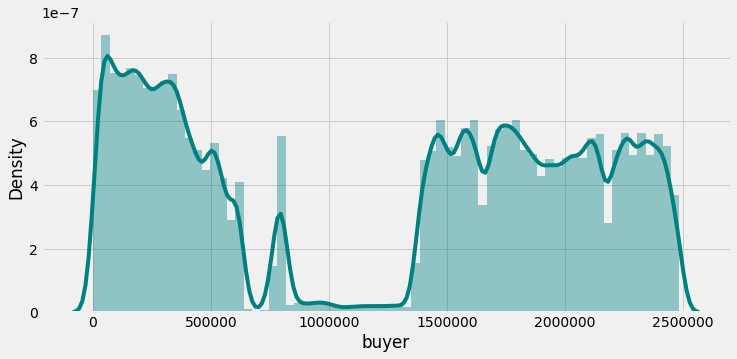

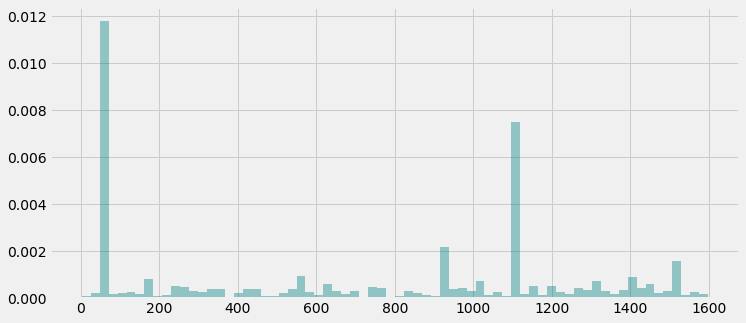

In [26]:
import seaborn as sns
plt.style.use('fivethirtyeight')
for c in ['buyer', 'buyer_trader','seller', 'seller_trader','sell_PLimSaiOm', 'sell_NSeqOm10','DEvenRLC','NTranSeaBs','PTran','NTranSeaBs','Buy_NSeqOm10',]:
    plt.figure(figsize=(11, 5))
    sns.distplot(data[c], kde=True,bins=70,  color='teal')

In [29]:
data = data.sort_values(by='DEvenRLC')

In [30]:
data.head(30)

,DEvenRLC,HEvenRLC,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf,DEvenRLCDateTime,DSeaBsEvenDateTime
48758600,20190731,91521,IRO7LKPP0001,20190731,102,210,32330.0,7.0,1103.0,1823577.0,32330.0,396.0,2.019073e+13,639.0,1417584.0,32300.0,397.0,2.019073e+13,2019-07-31,2019-07-31
50011105,20190731,91344,IRO3KHZZ0001,20190731,16,68,14999.0,7.0,61.0,336962.0,15189.0,171.0,2.019073e+13,61.0,186809.0,14999.0,166.0,2.019073e+13,2019-07-31,2019-07-31
50135481,20190731,90016,IRO7SHEP0001,20190731,116,25,74000.0,7.0,1101.0,2000107.0,80000.0,400.0,2.019073e+13,433.0,609018.0,71453.0,223.0,2.019073e+13,2019-07-31,2019-07-31
50135511,20190731,120906,IRO3SHHZ0001,20190731,2406,300,3600.0,7.0,185.0,441618.0,3600.0,4330.0,2.019073e+13,1103.0,1872327.0,3600.0,4309.0,2.019073e+13,2019-07-31,2019-07-31
50135510,20190731,112151,IRO3ANQZ0001,20190731,434,500,16050.0,7.0,1371.0,2256375.0,16050.0,581.0,2.019073e+13,1164.0,2105750.0,16000.0,1197.0,2.019073e+13,2019-07-31,2019-07-31
50135509,20190731,120809,IRO3ANQZ0001,20190731,580,8900,16166.0,7.0,1582.0,2483992.0,16166.0,1498.0,2.019073e+13,1164.0,2105750.0,16100.0,1521.0,2.019073e+13,2019-07-31,2019-07-31
50135508,20190731,94339,IRO7MFMP0001,20190731,545,700,63020.0,7.0,1103.0,1992054.0,63020.0,1956.0,2.019073e+13,1103.0,1763620.0,63020.0,2004.0,2.019073e+13,2019-07-31,2019-07-31
50135507,20190731,115558,IRO3PZGZ0001,20190731,801,933,63901.0,7.0,1103.0,1778242.0,63901.0,2092.0,2.019073e+13,1164.0,2107102.0,63900.0,2097.0,2.019073e+13,2019-07-31,2019-07-31
50135506,20190731,94233,IRO7TRKP0001,20190731,170,22637,17200.0,7.0,1103.0,1918716.0,17200.0,560.0,2.019073e+13,1011.0,1717787.0,17200.0,574.0,2.019073e+13,2019-07-31,2019-07-31
50135477,20190731,102539,IRO7ARNP0001,20190731,821,24250,1831.0,7.0,1523.0,2424363.0,1831.0,2151.0,2.019073e+13,984.0,1678527.0,1830.0,2165.0,2.019073e+13,2019-07-31,2019-07-31
